# **Calibration: Fairness in Recommender Systems**

Implementação da dissertação ["Explorando Justiça em Sistemas de Recomendação: Calibragem Ponderada, Balanceamentos e Métricas"](https://sol.sbc.org.br/index.php/webmedia_estendido/article/view/21975/21798) dos pesquisadores Diego Corrêa da Silva (diego.correa@ufba.br) e Frederico Araújo Durão (fdurao@ufba.br).

A dissertação busca avaliar algoritmos, métricas e medidas para resolver problemas de precisão e injustiça em sistemas de recomendação, por meio da calibragem, e desenvolver um modelo de sistema e um protocolo de decisão para recomendação calibradas.

> [Código original](https://github.com/DiegoCorrea/Exploiting-Personalized-Calibration-and-Metrics-for-Fairness-Recommendation/)



In [ ]:
%pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357232 sha256=8f32749cb9bc2f3e1859ae91954e1f46203dbca5059005125319f1c97a5bd317
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import random

In [ ]:
my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

## **0. Carregamento do dataset**

Como é comumente é feito, será utilizado duas bases da dados públicas: [Movielens 20M](https://grouplens.org/datasets/movielens/) e [One Milion Songs (OMS)](http://millionsongdataset.com/pages/getting-dataset/). Para esta implementação, serão utilizados um subset do primeiro dataset. Além disso, serão definidos algumas constantes para fazer uma relação do código para com o artigo.


In [ ]:
TITLE_LABEL = 'title'
GENRE_LABEL = 'genres'
USER_LABEL = 'userId'
ITEM_LABEL = 'itemId'
VALUE_LABEL = 'rating'
CANDIDATES_LIST_SIZE = 100
RECOMMENDATION_LIST_SIZE = 10

In [ ]:
movie_columns = [ITEM_LABEL, TITLE_LABEL, GENRE_LABEL]
ratings_columns = [USER_LABEL, ITEM_LABEL, VALUE_LABEL, "timestamp"]

movies = pd.read_csv("./movies.csv", names=movie_columns, skiprows=1)
ratings = pd.read_csv("./ratings.csv", names=ratings_columns, skiprows=1)

data = movies.merge(ratings, on=ITEM_LABEL)
data.head()

,itemId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [ ]:
data.drop(columns=["timestamp"], inplace=True)
for column in [USER_LABEL, ITEM_LABEL]:
    data[column] = data[column].astype("category")
data.head()

,itemId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


### **Distribuição das notas**

Perceba que segue praticamente uma distribuição normal, onde as notas se concentram na média e poucas notas alcançam o topo como nota 5, até menos que a quantidade de filmes que receberam a menor nota. Mostrando que as pessoas tendem a classificar filmes ruins de forma mais fácil, ou simplesmente a amostra possui mais filmes ruins.

Text(0.5, 1.0, 'Histograma das notas dos filmes')

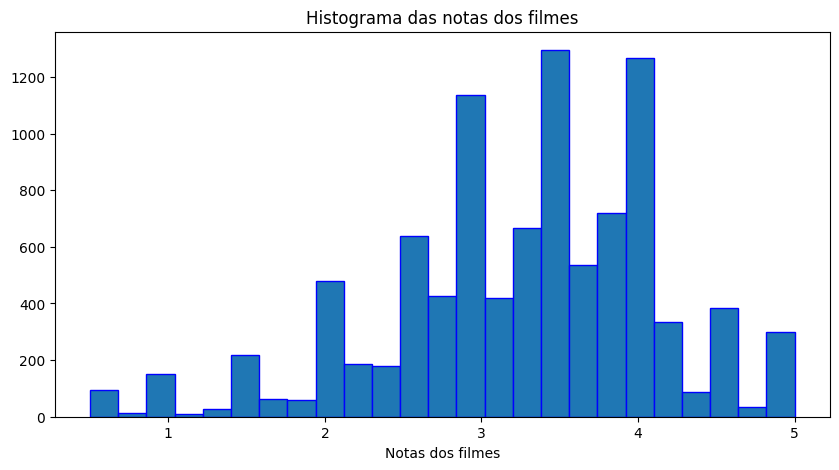

In [ ]:
dftmp = data[[ITEM_LABEL, VALUE_LABEL]].groupby(ITEM_LABEL).mean()
dftmp.hist(bins=25, grid=False, edgecolor='b', label ='Notas', figsize=(10,5))
plt.xlabel('Notas dos filmes')
plt.title('Histograma das notas dos filmes')

### **Distribuição por usuário**

Perceba que 95% dos usuários avaliam acima de 2.5, onde os usuários são representados pela curva CDF. Pode ser simplesmente porque os usuários costumam sempre assistir bons filmes, ou apenas se interessam em classificar os bons filmes e não os ruins.

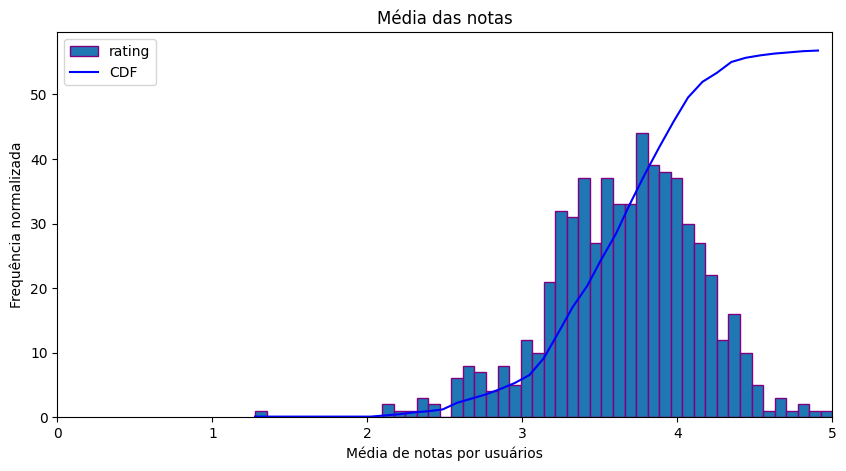

In [ ]:
dftmp = data[[USER_LABEL, VALUE_LABEL]].groupby(USER_LABEL).mean()
dftmp.plot(kind='hist', bins=50, grid=0, edgecolor='purple', figsize=(10,5))

values, base = np.histogram(dftmp, bins=40)
cumulative = np.cumsum(values) * np.diff(base).mean()

plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Média de notas por usuários')
plt.ylabel ('Frequência normalizada')
plt.title ('Média das notas')
plt.show()

### **Filmes por ano**

O número de filmes foram crescendo exponencialmente até o ano 2000, e passou a diminuir cada vez mais até despencar significamente próximo de 2020.

In [ ]:
# Extraindo os anos dos filmes
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year
movies.title = movies.title.str[:-7]

movies.head()

,itemId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


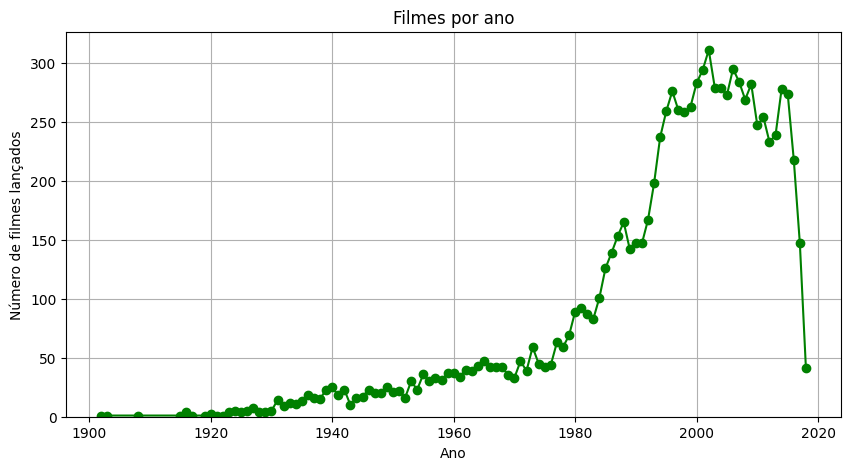

In [ ]:
# Plotando os filmes por ano
dftmp = movies[[ITEM_LABEL, 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.itemId.nunique(), "g-o")
ax1.grid(None)
ax1.set_ylim(0,)

ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de filmes lançados');
plt.title('Filmes por ano')
plt.show()

### **Avaliações dos filmes por ano**

Perceba que com o decorrer do tempo, o número de avaliações negativas começaram a aparecer, coisa que não existia antes. Além disso, as avaliações após 1980 se concentram entre nota 2 e 4,5.

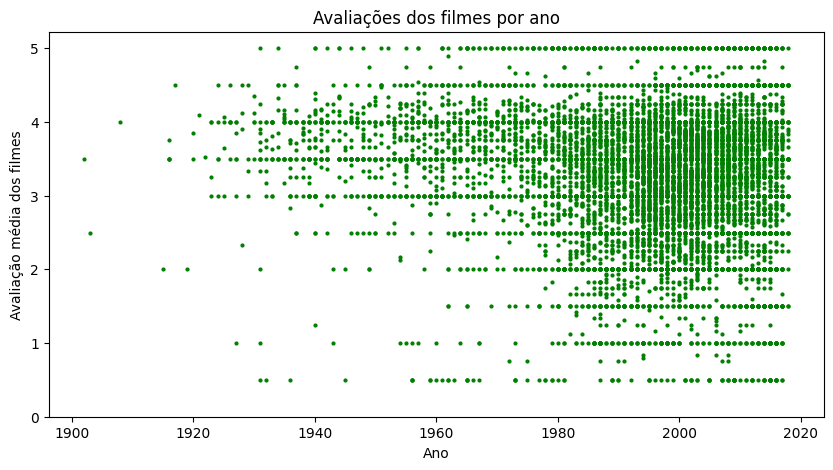

In [ ]:
dftmp = movies[[ITEM_LABEL, 'year']].set_index(ITEM_LABEL).join(
    ratings[[ITEM_LABEL, VALUE_LABEL]].groupby(ITEM_LABEL).mean())

plt.figure(figsize=(10,5))
plt.plot(dftmp.year, dftmp.rating,"g.", markersize=4)
plt.xlabel('Ano')
plt.ylabel('Avaliação média dos filmes')
plt.title('Avaliações dos filmes por ano')
plt.ylim(0,)
plt.show()

### **Análise dos gêneros**

Os gêneros dos filmes foram divididos de forma a analisá-los individualmente, então foi selecionado os 5 maiores gêneros e plotado um gráfico de pizza com esse resultado. Perceba que o gêneros de Drama é o mais predominante, seguido por comédia.

In [ ]:
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre'])
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

movies.head()

,itemId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995.0,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


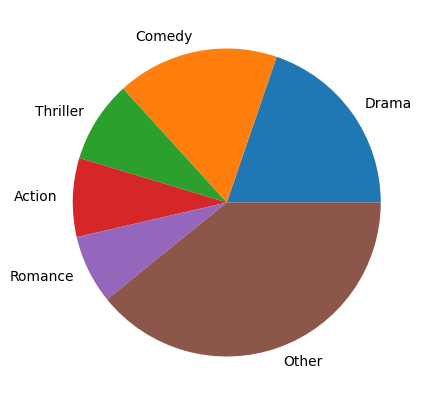

In [ ]:
genre_count = { key: 0 for key in genres_unique["genre"] }
for genre in genre_count:
    count = movies[genre].value_counts()[True]
    genre_count[genre] = count

genre_count = pd.DataFrame.from_dict(genre_count, orient='index')
genre_count.columns = ['count']
genre_count.sort_values(by='count', ascending=False, inplace=True)

genre_count.reset_index(inplace=True)
genre_count.rename(columns={'index': 'genre'}, inplace=True)
other_count = genre_count[5:]["count"].sum()
genre_count = genre_count[:5]
genre_count.loc[5] = ["Other", other_count]

plt.figure(figsize=(10,5))
plt.pie(genre_count['count'], labels=genre_count["genre"])
plt.show()

## **1. Pré-processamento**

Esta etapa foca em preprar os dados para o sistema calibrado e é composta pelas etapas de limpeza, filtragem e modelagem, é focada em preparar os da-
dos para o sistema. Os datasets serão divididos em 70% dos dados para treinamento e 30% para teste.

In [ ]:
randomized_data = data.sample(frac=1, random_state=my_seed)
threshold = int(0.7 * len(data))

trainset_data = randomized_data[:threshold]
testset_data = randomized_data[threshold:]
len(trainset_data), len(testset_data)

(70585, 30251)

### **1.1. Criação do dataset de treino e teste**

É utilizado o objeto *Dataset* da biblioteca _Surprise_ para  criar o dataset de treino e teste já dividido na etapa anterior. Perceba que para realizar essas etapas serão utilizados apenas o ID do usuário, do item e a avaliação.

In [ ]:
def get_testset(data: pd.DataFrame):
    """
    Args:
        data: Dados de teste.

    Returns:
        Dataset de teste.
    """
    reader = Reader()
    testset_ds = Dataset.load_from_df(data, reader)
    testset = testset_ds.build_full_trainset()
    return testset.build_testset()

users_columns = [USER_LABEL, ITEM_LABEL, VALUE_LABEL]
items_columns = [ITEM_LABEL, TITLE_LABEL, GENRE_LABEL]

trainset_df = trainset_data[users_columns]
testset_df = testset_data[users_columns]

reader = Reader()
trainset_ds = Dataset.load_from_df(trainset_df, reader)
trainset = trainset_ds.build_full_trainset()

testset = get_testset(testset_df)

itemset = data[items_columns].drop_duplicates()
itemset.head()

,itemId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
215,2,Jumanji (1995),Adventure|Children|Fantasy
325,3,Grumpier Old Men (1995),Comedy|Romance
377,4,Waiting to Exhale (1995),Comedy|Drama|Romance
384,5,Father of the Bride Part II (1995),Comedy


### **1.2. Componente de Distribuição dos Gêneros**

Esta etapa visa definir as funções para se obter a **distribuição alvo**, baseado nos dados reais do usuário, e a **distribuição realizada**, baseado na lista de recomendação resultante dos modelos de recomendação, são utilizadas as funções de extração da distribuição p(g|i) e p(g|u).

#### **1.2.1. Função de identificação da importância**

É definido a função **p(g|i)**, que identifica o valor da importância do gênero _g_ no item _i_. Essa função é dada pela probabilidade de cada gênero para cada ítem, ou seja:

$$
p(g|i) = \frac{1}{genresIn(i)}
$$
Onde _g_ é o gênero e _i_ é o ítem, e a função _genresIn_ está obtendo cada gênero de _i_.

> Lembrando que o gênero para nosso caso é cada gênero de filme e cada ítem é os filmes em si.

In [ ]:
from dataclasses import dataclass

@dataclass
class Item:
    id: int
    title: str
    genres: dict[str, float]
    score: int = 0

def compute_item_dist(dataframe: pd.DataFrame) -> dict[int, Item]:
    """
    Args:
        dataframe: Dados com todos os itens possíveis.

    Returns:
        Dicionário com a probabilidade de cada gênero para cada ítem.
    """
    item_mapping: dict[int, Item] = dict()
    for row in dataframe.itertuples():
        item_id: int = getattr(row, ITEM_LABEL)
        item_title: str = getattr(row, TITLE_LABEL)
        genre_list: list[str] = getattr(row, GENRE_LABEL).split('|')

        genre_ratio = 1. / len(genre_list)
        item_genre: dict[str, float] = {
            genre: genre_ratio for genre in genre_list
        }

        item = Item(item_id, item_title, item_genre)
        item_mapping[item_id] = item

    return item_mapping

#### **1.2.2. Função de extração das distribuições**

É otido a **distribuição alvo** a partir dos dados reais, com a seguinte fórmula:

$$
p(g|u)=\frac{\sum_{i \in Iu} 1(g \in i) Wu,i \cdot p(g|i)} {\sum_{i \in Iu} 1(g \in i) Wu,i}
$$

Perceba que ele está iterando cada item sobre o $Iu$, ou seja os ítens do usuário. Então multiplica cada peso (rating) do item $Wu,i$ pela distribuição de itens obtida anteriormente $p(g|i)$. Por fim, divide isso pela soma dos pesos dos itens $\sum_{i} Wu,i$. A função $1(g \in i)$ faz com que o valor seja 0 caso o gênero _g_ não estiver no item _i_.

A função para se obter a **distribuição realizada** é a mesma, porém aplicada sobre a as recomendações:

$$
q(g|u)=\frac{\sum_{i \in CIu} 1(g \in i) Wr(u,i) \cdot p(g|i)} {\sum_{i \in CIu} 1(g \in i) Wr(u,i)}
$$

Perceba que agora ele irá iterar cada item pertencente aos itens candidatos para o usuário $CIu$. Além disso, os pesos agoram são sobre a predição dos modelos $Wr(u,i)$.

In [ ]:
from copy import deepcopy

def join_user_to_item_dist(user_df: pd.DataFrame,
                           item_dist: dict[int, Item]) -> dict[int, Item]:
    """
    Args:
        user_df: Dados com os usuários.
        item_dist: Dicionário com a probabilidade de cada gênero para cada ítem.

    Returns:
        Dicionário que une os usuários com a distribuição dos itens.
    """
    user_items: dict[int, Item] = dict()
    for row in user_df.itertuples():
        item_id: int = getattr(row, ITEM_LABEL)
        user_items[item_id] = deepcopy(item_dist[item_id])
        user_items[item_id].score = getattr(row, VALUE_LABEL)
    return user_items

def compute_user_dist(user_items: dict[int, Item]) -> dict[str, float]:
    """
    Soma as pontuações ponderadas dos itens do usuário e
    divide pela soma dos pesos dos itens do usuário.

    Args:
        user_items: Dicionário que une os usuários com a distribuição dos itens.

    Returns:
        Dicionário com a probabilidade de cada gênero para cada usuário.
    """
    user_dist: dict[str, float] = dict()
    weigth_acc: dict[str, float] = dict()
    for item in user_items:
        item_class = user_items[item]
        item_weigth = item_class.score
        for genre, score in item_class.genres.items():
            genre_score = user_dist.get(genre, 0.)
            weigth_rating = weigth_acc.get(genre, 0.)
            weigth_acc[genre] = weigth_rating + item_weigth
            user_dist[genre] = genre_score + (score * item_weigth)

    for genre, genre_score in user_dist.items():
        weigth = genre_score / weigth_acc[genre]
        user_dist[genre] = round(weigth, 3)
    return user_dist

def get_user_distribution(user_df: pd.DataFrame,
                          item_mapping: dict[int, Item]) -> dict[str, float]:
    """
    Args:
        user_df: Dados com os usuários.
        item_mapping: Dicionário com a probabilidade de cada gênero para cada ítem.

    Returns:
        Dicionário com a probabilidade de cada gênero para cada usuário.
    """
    items = join_user_to_item_dist(user_df, item_mapping)
    return compute_user_dist(items)

In [ ]:
item_mapping = compute_item_dist(itemset)

user_dist_list: list[pd.DataFrame] = list()
for user_id in trainset_df[USER_LABEL].unique():
    user_df = trainset_df[trainset_df[USER_LABEL] == user_id]
    user_mapping = join_user_to_item_dist(user_df, item_mapping)
    user_dist = pd.DataFrame(compute_user_dist(user_mapping), index=[user_id])
    user_dist_list.append(user_dist)
user_dist_df = pd.concat(user_dist_list, sort=False).fillna(0.0)
user_dist_df.head()

,Action,Mystery,Thriller,Comedy,War,Adventure,Animation,Drama,Romance,Horror,Sci-Fi,Children,Crime,Film-Noir,Musical,Western,Documentary,IMAX,Fantasy,(no genres listed)
599,0.334,0.316,0.337,0.509,0.351,0.304,0.287,0.492,0.376,0.399,0.332,0.311,0.338,0.287,0.345,0.459,0.836,0.260,0.296,1.0
282,0.309,0.289,0.314,0.517,0.380,0.287,0.229,0.481,0.373,0.481,0.329,0.225,0.374,0.000,0.305,0.333,1.000,0.272,0.262,0.0
414,0.324,0.301,0.354,0.513,0.373,0.305,0.263,0.516,0.398,0.381,0.327,0.287,0.350,0.306,0.366,0.520,0.887,0.251,0.295,0.0
136,0.299,0.337,0.373,0.558,0.318,0.278,0.182,0.506,0.367,0.476,0.317,0.230,0.317,0.000,0.176,0.333,0.000,0.167,0.279,0.0
58,0.306,0.333,0.386,0.529,0.345,0.301,0.215,0.472,0.379,0.500,0.349,0.245,0.356,0.000,0.259,0.308,0.000,0.250,0.259,0.0


## **2. processamento**

Nesta etapa são executados os algoritmos de recomendação. A dissertação utiliza 9 algoritmos recomendadores, nem todos serão exibidos neste notebook:
1. **User based K Nearest Neighbors (User-KNN)**
2. **Item based K Nearest Neighbors (Item-KNN)**
3. **Slope One**
4. **Non-negative Matrix Factorization**
5. **Singular Value Decomposition (SVD)**
6. **Singular Value Decomposition Plus Plus (SVD++)**
8. **Co-Clustering**
9. Melhor nota
10. Popularidade

In [ ]:
from surprise import SVD, SVDpp, KNNWithMeans, SlopeOne, NMF, CoClustering

algo_models = {
    "nmf": NMF,
    "svd": SVD,
    "svdpp": SVDpp,
    "slopeone": SlopeOne,
    "user_knn": KNNWithMeans,
    "item_knn": KNNWithMeans,
    "coclustering": CoClustering
}

### **2.1. Definição do espaço de parâmetros**

Apesar dos autores não utilizarem, eles recomendaram que cada um dos algoritmos fossem otimizados com o _Grid Search_. Para a definição do espaço de hiperparâmetros foi utilizado sempre os parâmetros definidos pela dissertação e pelo menos mais algum outro parâmetro.

In [ ]:
models_params = {
    "svd": {
        "n_epochs": [10, 20],
        "n_factors": [10, 20],
        "lr_all": [0.002, 0.005],
        "reg_all": [0.01, 0.02],
        "random_state": [42]
    },
    "svdpp": {
        "n_epochs": [10, 20],
        "n_factors": [10, 20],
        "lr_all": [0.002, 0.005],
        "reg_all": [0.01, 0.02],
        "random_state": [42]
    },
    "user_knn": {
        "k": [10, 20, 30],
        "min_k": [1, 3],
        "sim_options": {
            'name': ['pearson_baseline'],
            "user_based": [True]
        }
    },
    "item_knn": {
        "k": [10, 20, 30],
        "min_k": [1, 3],
        "sim_options": {
            'name': ['pearson_baseline'],
            "user_based": [False]
        }
    },
    "slopeone": {},
    "coclustering": {
        "n_epochs": [5, 10],
        "n_cltr_u": [3, 5, 10],
        "n_cltr_i": [3, 5, 10],
    },
    "nmf": {
        "biased": [True],
        "n_epochs": [25, 50],
        "random_state": [42],
        "n_factors": [10, 15]
    },
}

### **2.2 Otimização dos algoritmos**

Esta etapa faz a busca do melhor modelo para cada um dos algoritmos, por fim, é treinado o modelo com os dados de treinamento. É utilizado o _trainset_ds_ por uma limitação da biblioteca _Surprise_ que exige um objeto _Dataset_ para executar o GridSearchCV.

In [ ]:
models = dict()

for algo, model in tqdm(algo_models.items(), total=len(algo_models)):
    params = models_params[algo]
    grid = GridSearchCV(model, params, cv=5, n_jobs=-1,
                        measures=["rmse"])
    grid.fit(trainset_ds)
    models[algo] = grid.best_estimator["rmse"]

100%|██████████| 6/6 [40:17<00:00, 402.89s/it]


In [ ]:
for algo, model in models.items():
    models[algo] = model.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


## **3. pós-processamento**

Esta é a etapa principal dos sistemas de recomendação. A dissertação propõe construir aqui um modelo de sistema para recomendação calibrada, composto por alguns componentes.

In [ ]:
def get_user_unknown_items(user_id: int, user_trainset_df: pd.DataFrame,
                           item_mapping: dict[int, Item]) -> pd.DataFrame:
    """
    Args:
        user_id: ID do usuário.
        user_trainset_df: Dados de treinamento do usuário.
        item_mapping: Dicionário com a probabilidade de cada gênero para cada ítem.

    Returns:
        Dataframe com os itens não avaliados pelo usuário.
    """
    user_items_ids = user_trainset_df[ITEM_LABEL].unique().tolist()
    all_items_ids = item_mapping.keys()
    return pd.DataFrame({
        USER_LABEL: user_id,
        ITEM_LABEL: list(set(all_items_ids) - set(user_items_ids)),
        VALUE_LABEL: 0.0
    })

In [ ]:
from collections import defaultdict

def get_user_pred_df(user_ratings: tuple[int, list[tuple[int, float, float]]],
                     n_items_to_filter: int) -> pd.DataFrame:
    """
    Args:
        user_ratings: Mapeamento de usuários para predição do usuário.
        n_items_to_filter: Número de itens a serem filtrados.

    Returns:
        Dataframe com as N predições do usuário.
    """
    pred_columns = [USER_LABEL, ITEM_LABEL, VALUE_LABEL, "original_rating"]
    top_n_df = pd.DataFrame()
    uid, ratings = user_ratings
    ratings.sort(key=lambda x: x[1], reverse=True)
    for iid, est, true_r in ratings[:n_items_to_filter]:
        new_row = pd.DataFrame(data=[[uid, iid, est, true_r]],
                               columns=pred_columns)
        top_n_df = pd.concat([top_n_df, new_row])
    return top_n_df

def get_candidates_items(predictions: list[tuple[int, int, float, float, dict]],
                         n=CANDIDATES_LIST_SIZE) -> pd.DataFrame:
    """
    Devolve uma lista de N recomendações a partir da lista de predições.

    Args:
        predictions: Lista de predições dadas por um algoritmo.
        n: Número de recomendações a serem devolvidas.

    Returns:
        Dataframe com as N recomendações.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))
    map_results_df = [get_user_pred_df(user, n) for user in top_n.items()]
    return pd.concat(map_results_df, sort=False)

In [ ]:
def convert_items_dict_to_df(recommendations: dict[int, Item]) -> pd.DataFrame:
    """
    Converte um dicionário de itens para um dataframe.

    Args:
        recommendations: Dicionário de itens

    Returns:
        Dataframe com os itens
    """
    results_df = pd.DataFrame()
    user_results: list[pd.DataFrame] = list()
    for order, (item_id, item) in enumerate(recommendations.items()):
        user_results += [pd.DataFrame(data=[[item_id, item.score, order]],
                                      columns=[ITEM_LABEL, VALUE_LABEL, "order"])]
    return pd.concat(user_results, sort=False)

### **3.1. Componente de Medida de Justiça**

Esta etapa calcula a medida de divergência, que é a distância entre a distribuição realizada e a distribuição alvo. A dissertação testa as seguintes medidas de divergência, no qual as duas últimas são propostas da dissertação, porém só será utilizada a última, uma vez que demonstrou melhor desempenho:
1. Kullback-Leibler: Uma divergência de Kullback-Leibler igual a 0 indica que as funçõe/distribuições P e Q são muito parecidas (iguais, até), enquanto uma divergência de 1 indica que se comportam de maneira diferente. Queremos que a divergência entre a distribuição alvo e distribuição realizada seja a menor possível.
2. Hellinger: Seguindo a mesma lógica, o valor da distância de Hellinger indica o quão diferentes as duas distribuições são. Quanto menor o valor, mais próximas estão as distribuições.
3. **Pearson Chi-Square**: Este teste é usado para comparar duas distribuições de frequência e verificar se são significativamente diferentes, sendo definido por:

$$
PC(p,q) = \sum_{g \in G} \frac{(p(g|u) - q'(g|u))^2}{q'(g|u)}
$$


In [ ]:
import math

def compute_pearson_chi_square(user_genre_dist: pd.Series,
                              user_candidates: dict[str, float],
                              alpha: float=0.01) -> float:
    """
    Calcula o Chi-Square, onde quanto menor, melhor.

    Args:
        user_genre_dist: Probabilidade de cada gênero para o usuário
        user_candidates: Mapeamento de valor de cada gênero para um ítem
        alpha: Peso do balanceamento lambda

    Returns:
        Valor do Chi-Square
    """
    sum_value = 0.
    for genre, p in user_genre_dist.items():
        q = user_candidates.get(genre, 0.)
        til_q = (1 - alpha) * q + alpha * p
        if math.isnan(til_q) or til_q == 0.0:
            temp_value = 0.0
        else:
            temp_value = np.power((p - til_q), 2.0) / til_q # AQUI
        if math.isnan(temp_value):
            temp_value = 0.0
        sum_value += temp_value
    return sum_value

### **3.2. Componente do Peso do Balanceamento**

Normalmente os sistemas de recomendação utilizam um peso constante 𝜆 para balancear a relevância do ranque com as medidas de divergência. Mas a dissertação utiliza duas formulações para encontrar o valor 𝜆 de forma personalizada.

#### **3.2.1. Variância (VAR)**

Utiliza a variância para encontrar a dispersão dos gêneros no perfil do usuário. Em termos simples, a variância mede o quão dispersos estão os interesses do usuário entre diferentes gêneros. É definido por:

$$
mp(u) = \frac{\sum_{g \in G} p(g|u)}{|G|}
$$

$$
var(u)=\frac{\sum_{g \in G} |p(g|u) - mp(u)|^2}{|G|}
$$

$$
\lambda u = 1 - var(u)
$$

In [ ]:
def get_lmbda_by_variance(user_genre_dist: pd.Series) -> float:
    """
    Args:
        user_genre_dist: Probabilidade de cada gênero para o usuário

    Returns:
        Valor do lambda
    """
    return 1 - user_genre_dist.var()

#### **3.2.2. Contagem de gêneros (CGR)**

Conta-se quantos gêneros o usuário possui e divide-se pelo número total de gêneros no sistema. Isso oferece uma medida de quão diversificado é o perfil de interesses do usuário em relação ao conjunto total de gêneros disponíveis.

$$
h(u,g) = \{1, otherwise^{0,ifp(g|u)=0}
$$

$$
\lambda u = \frac{\sum_{g \in G} h(u,g)}{|G|}
$$

In [ ]:
def get_lmbda_by_count_genres(user_genre_dist: pd.Series) -> float:
    """
    Args:
        user_genre_dist: Probabilidade de cada gênero para o usuário

    Returns:
        Valor do lambda
    """
    count = 0
    for i, number in user_genre_dist.items():
        if number > 0.0:
            count += 1
    return count / len(user_genre_dist)

### **3.3. Componente de Balanceamento**

A partir de um certo 𝜆 obtido na etapa anterior, será realizado o balanceamento para a calibragem. Nesta etapa também são propostas duas abordagens pela dissertação. Mas só iremos implementar a abordagem estado-da-arte (LIN).

A outra abordagem é a Longarítmica (LOG) que tem o objetivo de considerar os (1) gêneros, (2) itens e o (3) usuário no balanceamento, é utilizado o viés, adaptando assim a lista de recomendação de acordo com os itens inseridos na lista de recomendação, então utiliza a forma logarítimica para suavizar a curva e contar com a adição de um viés do usuário.
Exemplificando, pense em uma lista de filmes recomendados. A abordagem logarítmica suaviza o impacto da divergência, garantindo que a recomendação seja diversificada sem sacrificar demais a relevância dos filmes para o usuário.


#### **3.3.1. Maginal Relevance (MR)**

_Steck_ apresenta um balanceamento linear (LIN) dividida em duas partes, de forma que quanto maior a divergência, maior é a subtração no valor do ranque:

$$
s(CIu)=\sum_{i \in CIu}{Wr(u,i)}
$$

$$
MR(p, CIu)=(1 - λ) . s(CIu) - λ.F(p,q(CIu))
$$

Onde $s(CIu)$ é a soma dos pesos dos itens preditos, a função que devolve a medida de Fairness $F(p,q)$ é o _Pearson chi-square_ para o nosso caso e o valor de trade-off λ é dado pelo VAR ou CGR, responsável por indicar se o usuário prefere recomendações com maior similaridade $s(CIu)$ ou equidade $F(p,q)$.

Para exemplificar, imagine que você tem uma lista de músicas recomendadas. Se 𝜆𝑢 for alto, a fórmula vai diminuir a relevância se todas as músicas forem do mesmo gênero, incentivando a inclusão de diferentes gêneros na recomendação.


In [ ]:
def linear_calibration(candidates_mapping: dict[int, Item],
                       user_genre_dist: pd.Series,
                       lmbda: float=0.5) -> float:
    """
    Calcula a medida de calibragem linear.

    Args:
        candidates_mapping: Mapeamento de valor de cada gênero para um ítem
        user_genre_dist: Probabilidade de cada gênero para o usuário
        lmbda: Peso do balanceamento lambda

    Returns:
        Valor da medida de calibragem
    """
    candidates_dist = compute_user_dist(candidates_mapping)
    div_value = compute_pearson_chi_square(user_genre_dist, candidates_dist)

    total_score = 0.0
    for item in candidates_mapping.values():
        total_score += item.score

    return (1 - lmbda) * total_score - lmbda * div_value

### **3.4. Componente do Algoritmo de Seleção**

Será utilizado o Surrogate Submodular para  selecionar os itens, como está no estado-da-arte. Se trazindo na fórmula de Maximum Marginal Relevance (MMR), dado por:

$$
R^*= arg max MR(p, CIu)
$$

O Surrogate Submodular segue o seguinte algoritmo:

1. $R^*$ começa vazio $\{\}$;
2. Para cada iteração dos itens candidatos, se o item _i_ maximiza o $R^*$, então adicione à lista.
3. Por fim, a lista terá $n-1$ itens e o último item adicionado segue o MMR, completando os top-n itens $R^*$.

In [ ]:
def surrogate_submodular(user_genre_dist: pd.Series,
                         candidates_mapping: dict[int, Item],
                         n: int=RECOMMENDATION_LIST_SIZE, lmbda: float=0.5):
    """
    Inicia com uma lista de recomendação vazia e itera sobre os top N,
    atualizando a lista com os itens que maximizam a medida de calibragem.

    Args:
        user_genre_dist: Probabilidade de cada gênero para o usuário
        candidates_mapping: Mapeamento de valor de cada gênero para um ítem
        n: Número de itens a serem selecionados
        lmbda: Peso do balanceamento lambda

    Returns:
        Dicionário com os itens selecionados
    """
    selected_items: dict[int, Item] = {}
    for _ in range(n):
        max_utility = -np.inf
        best_item: Item = Item(-1, "", dict())
        best_id: int = -1
        for i_id, item in candidates_mapping.items():
            if i_id in selected_items.keys():
                continue
            temp = deepcopy(selected_items)
            temp[i_id] = item

            utility = linear_calibration(temp, user_genre_dist, lmbda)

            if utility > max_utility:
                max_utility = utility
                best_item = item
                best_id = i_id
        if best_id != -1:
            selected_items[best_id] = best_item
    return selected_items

### **3.5. Execução**

In [ ]:
users_len = len(user_dist_df.index)
candidates_per_user: dict[int, dict[str, dict[int, Item]]] = dict()
for index, user_id in tqdm(enumerate(user_dist_df.index), total=users_len):
    user_train_df = trainset_df[trainset_df[USER_LABEL] == user_id]
    user_unknown_items = get_user_unknown_items(user_id, user_train_df,
                                                item_mapping)
    candidates_per_model: dict[str, dict[int, Item]] = dict()
    for algo, model in models.items():
        candidates_pred = model.test(get_testset(user_unknown_items))
        candidates = get_candidates_items(candidates_pred)
        candidates_mapping = join_user_to_item_dist(candidates, item_mapping)

        candidates_per_model[algo] = candidates_mapping
    candidates_per_user[user_id] = candidates_per_model

100%|██████████| 610/610 [40:42<00:00,  4.00s/it]


In [ ]:
weights_variants = [("VAR", get_lmbda_by_variance),
                    ("CGR", get_lmbda_by_count_genres)]

recommendations_by_user = dict()
for user_id, user_genre_dist in tqdm(user_dist_df.iterrows(),
                                     total=users_len):
    recommendations_by_algo = dict()
    for algo, candidates_mapping in candidates_per_user[user_id].items():
        recommendations_by_weight = dict()
        for weight_label, weight_func in weights_variants:
            lmbda = weight_func(user_genre_dist)
            reco_items = surrogate_submodular(user_genre_dist,
                              candidates_mapping, lmbda=lmbda)
            reco_dfs = convert_items_dict_to_df(dict(reco_items))
            reco_dfs.sort_values(by="order", inplace=True)
            recommendations_by_weight[weight_label] = reco_dfs
        recommendations_by_algo[algo] = recommendations_by_weight
    recommendations_by_user[user_id] = recommendations_by_algo

100%|██████████| 610/610 [19:23<00:00,  1.91s/it]


## **4. Protocolo de Decisão**

Nesta etapa a dissertação propõe a criação de um protocolo de decisão para recomendação calibrada, composto por duas métrica, dois coeficientes e a decisão.

In [ ]:
def get_mrr_from_list(relevance_array):
    """
    Args:
        relevance_array: Mapeamento de cada recomendação
        para com o array de teste.

    Returns:
        Valor do MRR
    """
    relevance_list_size = len(relevance_array)
    if relevance_list_size == 0:
        return 0.0

    for i in range(relevance_list_size):
        if relevance_array[i]:
            return 1 / (i + 1)
    return 0.0

def compute_mrr(recommendations: pd.DataFrame,
                test_items_ids: list[int]) -> float:
    """
    Args:
        recommendations: Dataframe com os itens recomendados
        test_items_ids: Lista de itens de teste

    Returns:
        Valor do MRR
    """
    items_array = recommendations[ITEM_LABEL].tolist()
    precision = [x in test_items_ids for x in items_array]
    return get_mrr_from_list(precision)

### **4.1. Métricas**

Desconsiderando a métrica _Miscalibration_ comumente utilizado, uma vez que não considera a ordem do ranque, a dissertação propõe duas outras métricas de avaliação para o contexto da calibragem:

In [ ]:
def get_ap_from_list(relevance_array: list[bool]) -> float:
    """
    Args:
        relevance_array: Mapeamento de cada recomendação
        para com o array de teste.

    Returns:
        Valor do AP (Average Precision)
    """
    relevance_list_size = len(relevance_array)
    if relevance_list_size == 0:
        return 0.0

    hit_list = list()
    relevant = 0
    for i in range(relevance_list_size):
        if relevance_array[i]:
            relevant += 1
        hit_list.append(relevant / (i + 1))
    ap = sum(hit_list)
    if ap > 0.0:
        return ap / relevance_list_size
    return 0.0


def compute_ap(recommendations: pd.DataFrame,
                test_items_ids: list[int]) -> float:
    """
    Args:
        recommendations: Dataframe com os itens recomendados
        test_items_ids: Lista de itens de teste

    Returns:
        Valor do MAP
    """
    items_array = recommendations[ITEM_LABEL].tolist()
    precision = [x in test_items_ids for x in items_array]
    return get_ap_from_list(precision)

#### **4.1.1. Mean Average Absolute Error (MACE)**

O MACE é uma métrica que ajuda a entender quão bem o sistema de recomendação está alinhado com os gostos dos usuários. Ele faz isso medindo a diferença média absoluta entre o que é recomendado e o que os usuários preferem, resumindo isso em um único valor que representa a precisão da calibragem para todos os usuários. É dado pela fórmula:

$$
CE(u,p,q)=\frac{\sum_{g \in G} |p(g|u) - q(g|u)|}{|G|}
$$

$$
ACE(u)=\frac{\sum_{j=1}^N CE(u,p,q(R^*@j))}{N}
$$

$$
MACE=\frac{\sum_{u \in U} ACE(u)}{|U|}
$$

In [ ]:
def calibration_error(user_genre_dist: pd.Series, reco_dist: dict[str, float]):
    """
    Args:
        user_genre_dist: Probabilidade de cada gênero para o usuário
        reco_dist: Probabilidade de cada gênero para os itens recomendados

    Returns:
        Valor de CE(u,p,q)
    """
    result = list()
    for k in reco_dist.keys():
        result.append(abs(float(user_genre_dist[k]) - float(reco_dist[k])))

    return sum(result) / len(user_genre_dist)

def compute_ace(user_genre_dist: pd.Series, recommendations: pd.DataFrame,
                item_mapping: dict[int, Item]) -> float:
    """
    Args:
        user_genre_dist: Probabilidade de cada gênero para o usuário
        recommendations: Dataframe com os itens recomendados
        item_mapping: Dicionário com a probabilidade de cada gênero para cada ítem.

    Returns:
        Valor de ACE (average calibration error)
    """
    result = list()
    for k in recommendations["order"].tolist():
        user_dist = get_user_distribution(recommendations[:k], item_mapping)
        result.append(calibration_error(user_genre_dist, user_dist))

    return sum(result) / len(result)

#### **4.1.2. Mean Rank MisCalibration (MRMC)**

Esta métrica considera a descalibragem entre as distribuições, observando cada posição da lista de recomendação. O cálculo é realizado utilizando a medida de divergência implementada pelo sistema. É dado pela seguinte fórmula:

$$
MC(p,q)=\frac{F(p,q)}{F(pq,q(\{\}))}
$$

$$
RMC(u)=\frac{\sum_{j=1}^N MC(p,q(R^*@j)}{N}
$$

$$
MRMC=\frac{\sum_{u \in U} RMC(u)}{|U|}
$$

In [ ]:
def compute_rmc(user_genre_dist: pd.Series, recommendations: pd.DataFrame,
                item_mapping: dict[int, Item]) -> float:
    """
    Args:
        user_genre_dist: Probabilidade de cada gênero para o usuário
        recommendations: Dataframe com os itens recomendados
        item_mapping: Dicionário com a probabilidade de cada gênero para cada ítem.

    Returns:
        Valor do RMC (rank miscalibration)
    """
    order_list = recommendations["order"].tolist()
    mc_value = 0.0
    for i in order_list:
        reco_distr = get_user_distribution(recommendations[:i], item_mapping)
        norm_dist = get_user_distribution(pd.DataFrame(), item_mapping)

        reco_chi = compute_pearson_chi_square(user_genre_dist, reco_distr)
        norm_chi = compute_pearson_chi_square(user_genre_dist, norm_dist)
        mc_value += reco_chi / norm_chi
    mc_value = mc_value / len(order_list)
    return mc_value

### **4.2. Execução**

In [ ]:
EVALUATION_COLUMNS = ["ALGORITHM", "LAMBDA", "METRIC", "METRIC_VAL"]

results_df = pd.DataFrame(columns=["USER"] + EVALUATION_COLUMNS)
for user_id, user_genre_dist in tqdm(user_dist_df.iterrows(),
                                     total=users_len):
    user_test_df = testset_df[testset_df[USER_LABEL] == user_id]
    test_items_ids = user_test_df[ITEM_LABEL].tolist()

    for algo, algo_reco in recommendations_by_user[user_id].items():
        for lmda_label, weight_recommendations in algo_reco.items():
            ap_value = compute_ap(weight_recommendations, test_items_ids)
            mrr = compute_mrr(weight_recommendations, test_items_ids)
            ace = compute_ace(user_genre_dist, weight_recommendations,
                              item_mapping)
            rmc = compute_rmc(user_genre_dist, weight_recommendations,
                                item_mapping)
            results_df = pd.concat([results_df, pd.DataFrame([
                [user_id, algo, lmda_label, "AP", ap_value],
                [user_id, algo, lmda_label, "MRR", mrr],
                [user_id, algo, lmda_label, "ACE", ace],
                [user_id, algo, lmda_label, "RMC", rmc],
            ], columns=["USER"] + EVALUATION_COLUMNS)])

100%|██████████| 610/610 [02:39<00:00,  3.83it/s]


### **4.3. Decisão**

A decisão é dada pela soma de dois coeficientes, onde o menor valor é considerado o melhor para ser implementado.

1. Coefficient of Calibration Error (CCE):
$\frac{MACE}{MAP}$
2. Coefficient of MisCalibration (CMC): $\frac{MRMC}{MAP}$

Até então só temos o AP (Average Precision), ACE (Average Calibration Error) e RMC (Rank MisCalibration) para cada usuário, então iremos tirar a média de cada um desses para obter o MAP, ACE e MRMC.

In [ ]:
best_algo = None
best_value = float('inf')

agg_result = results_df.groupby(["ALGORITHM", "LAMBDA", "METRIC"])["METRIC_VAL"].mean()
for (algorithm, lmbda), group in agg_result.groupby(["ALGORITHM", "LAMBDA"]):
    map_val = group[(algorithm, lmbda, 'AP')]
    cce = group[(algorithm, lmbda, 'ACE')] / map_val
    cmc = group[(algorithm, lmbda, 'RMC')] / map_val

    # Soma CCE e CMC
    sum_value = cce + cmc

    print(f"{algorithm} {lmbda}: {sum_value}")
    # Atualiza o melhor algoritmo se a soma for menor
    if sum_value < best_value:
        best_value = sum_value
        best_algo = (algorithm, lmbda)

print(f"\nO melhor algoritmo é {best_algo} com valor {best_value}")

item_knn CGR: 148.26478221464154
item_knn VAR: 148.26478221464154
nmf CGR: 24.299303407607077
nmf VAR: 24.5619814639997
slopeone CGR: 57.779156217247035
slopeone VAR: 57.76710657153447
svd CGR: 5.1234366555020685
svd VAR: 5.045594419199135
svdpp CGR: 5.616183660188073
svdpp VAR: 5.635190426738161
user_knn CGR: 14.782814340940053
user_knn VAR: 14.155667863988509

O melhor algoritmo é ('svd', 'VAR') com valor 5.045594419199135
